In [1]:
import numpy as np
import matplotlib.pyplot as plt

path = "/Users/yhra/Documents/Master/Semester_3/MLFMM/UE/07/Pset07_files/"


# TASK 1: Dimensionality Reduction

In [2]:
X = np.load(path + "X.npy")
y = np.load(path + "y.npy")

# find how many unique labels there are
unique_labels = np.unique(y)
print(f"There are {len(unique_labels)} unique labels.")

print(X.shape)
print(y.shape)


There are 5 unique labels.
(511, 45768)
(511,)


## Train KMean Models

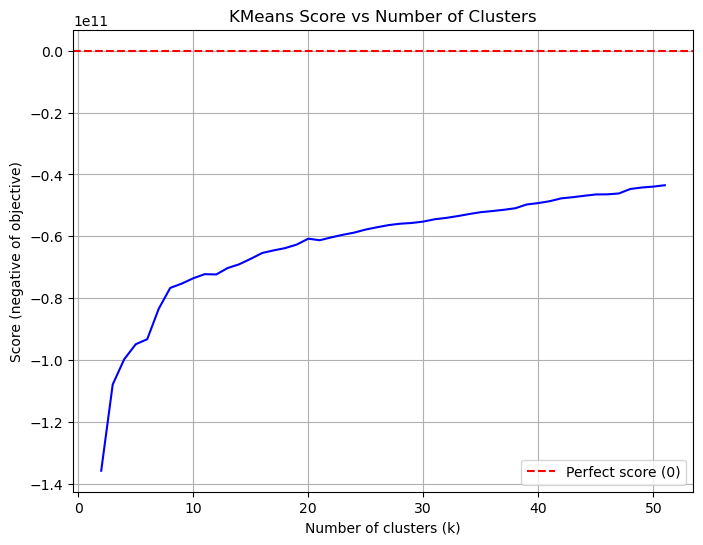

Number of samples: 511
The score approaches 0 as k approaches the number of samples,
since each point would become its own cluster.
This suggests the score alone is not a good metric for choosing k.


In [6]:
from sklearn.cluster import KMeans

# Train models with k=2 to k=50 and compute scores
scores = {}
wcss = {}
for k in range(2, 52):
    kmeans = KMeans(n_clusters=k, random_state=42, max_iter=500)
    kmeans.fit(X)
    scores[k] = kmeans.score(X)
    wcss[k] = kmeans.inertia_
# Plot the scores vs number of clusters
plt.figure(figsize=(8, 6))
plt.plot(list(scores.keys()), list(scores.values()), 'b-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Score (negative of objective)')
plt.title('KMeans Score vs Number of Clusters')
plt.grid(True)
plt.axhline(y=0, color='r', linestyle='--', label='Perfect score (0)')
plt.legend()
plt.show()

# The score approaches 0 as k approaches n_samples, since each point would be its own cluster
print(f"Number of samples: {X.shape[0]}")
print("The score approaches 0 as k approaches the number of samples,")
print("since each point would become its own cluster.")
print("This suggests the score alone is not a good metric for choosing k.")

In [7]:
def rotate_2D(x, theta):
    R = np.array ([[np.cos(theta), -np.sin(theta)],
                   [np.sin(theta), np.cos(theta)]])
    return np.einsum ("ij,kj->ki", R, x)

def kneedle(wcss , K):
    vecs = np.vstack ([K, wcss]).T
    vecs -= vecs[-1]
    vec = np.array([K[0]-K[-1], wcss [0] - wcss [ -1]])
    theta = np.arccos(vec [0]/np.linalg.norm(vec))
    new_vec = rotate_2D(vecs , -theta)
    return K[np.argmax(new_vec [: ,1])]

wcss_array = np.array(list(wcss.values()))
k_array = np.array(list(wcss.keys()))

print(f"The optimal number of clusters is {kneedle(wcss_array, k_array)}")
best_k = kneedle(wcss_array, k_array)


The optimal number of clusters is 8


## Train a KMeans model with the optimal number of clusters

In [9]:
opt_mod = KMeans(n_clusters=best_k,
                 random_state=42,
                 max_iter=500,
                 init="k-means++")
opt_mod.fit(X)

# compute normalized mutual information
from sklearn.metrics import normalized_mutual_info_score

nmi = normalized_mutual_info_score(y, opt_mod.labels_)
print(f"The normalized mutual information is {np.round(nmi, 3)}")

The normalized mutual information is 0.717


## Perform PCA

- How many features are needed to keep 95% of the explained variance?

In [10]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X)

# Calculate cumulative explained variance ratio
cum_var_ratio = np.cumsum(pca.explained_variance_ratio_)

# Find number of components needed for 95% variance
n_components = np.argmax(cum_var_ratio >= 0.95) + 1

print(f"Number of components needed to retain 95% of variance: {n_components}")
print(f"Cumulative explained variance ratio: {np.round(cum_var_ratio[n_components-1], 3)}")

# Reduce dimensions using PCA with optimal number of components
pca_transform = PCA(n_components=n_components)
X_reduced = pca_transform.fit_transform(X)

# Perform k-means on reduced data
opt_mod_reduced = KMeans(n_clusters=best_k, 
                        random_state=42,
                        max_iter=500,
                        init="k-means++")
opt_mod_reduced.fit(X_reduced)

# Compute NMI score for reduced dimensions
nmi_reduced = normalized_mutual_info_score(y, opt_mod_reduced.labels_)
print(f"The normalized mutual information with reduced dimensions is {np.round(nmi_reduced, 3)}")

# Compare with original NMI
print(f"\nComparison:")
print(f"Original NMI: {np.round(nmi, 3)}")
print(f"Reduced dimensions NMI: {np.round(nmi_reduced, 3)}")
if nmi_reduced > nmi:
    print("The clustering performance has improved with dimensionality reduction!")
else:
    print("The clustering performance has not improved with dimensionality reduction.")


Number of components needed to retain 95% of variance: 145
Cumulative explained variance ratio: 0.95
The normalized mutual information with reduced dimensions is 0.748

Comparison:
Original NMI: 0.717
Reduced dimensions NMI: 0.748
The clustering performance has improved with dimensionality reduction!


## Further dimensionality reduction with t-SNE

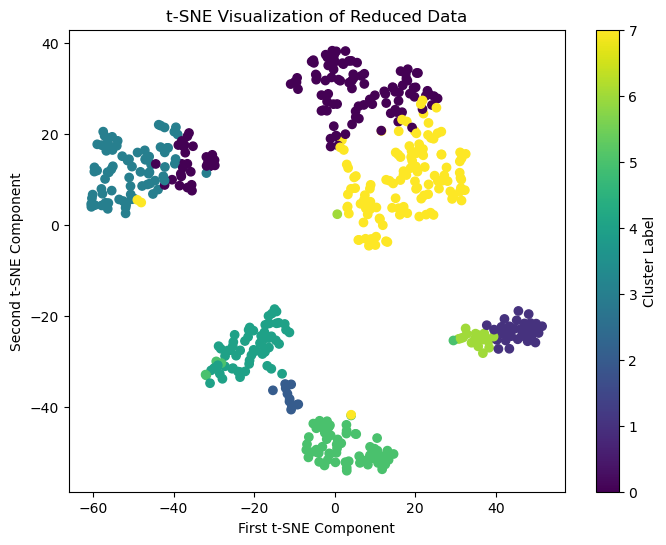

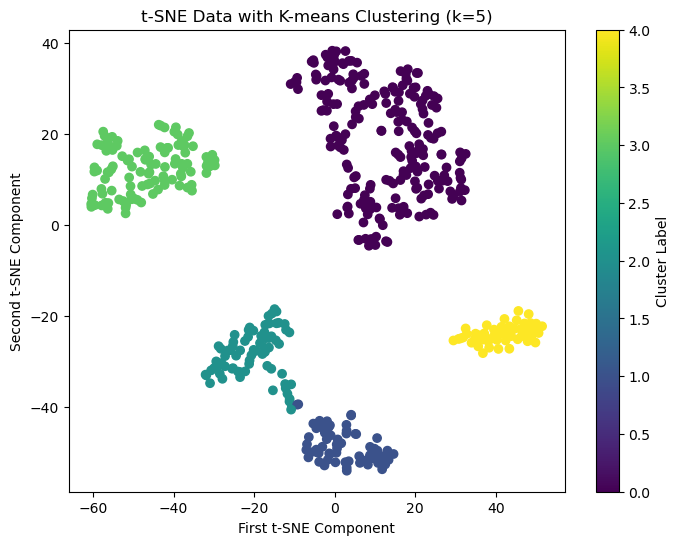

In [11]:
# Perform t-SNE dimensionality reduction
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=10, random_state=42)
X_tsne = tsne.fit_transform(X_reduced)

# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=opt_mod_reduced.labels_, cmap='viridis')
plt.title('t-SNE Visualization of Reduced Data')
plt.xlabel('First t-SNE Component')
plt.ylabel('Second t-SNE Component')
plt.colorbar(label='Cluster Label')
plt.show()

# Perform k-means clustering on t-SNE reduced data
kmeans_tsne = KMeans(n_clusters=5, random_state=42)
tsne_clusters = kmeans_tsne.fit_predict(X_tsne)

# Create scatter plot of t-SNE data colored by new cluster labels
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=tsne_clusters, cmap='viridis')
plt.title('t-SNE Data with K-means Clustering (k=5)')
plt.xlabel('First t-SNE Component')
plt.ylabel('Second t-SNE Component')
plt.colorbar(label='Cluster Label')
plt.show()




## Use Density-based clustering (DBSCAN)

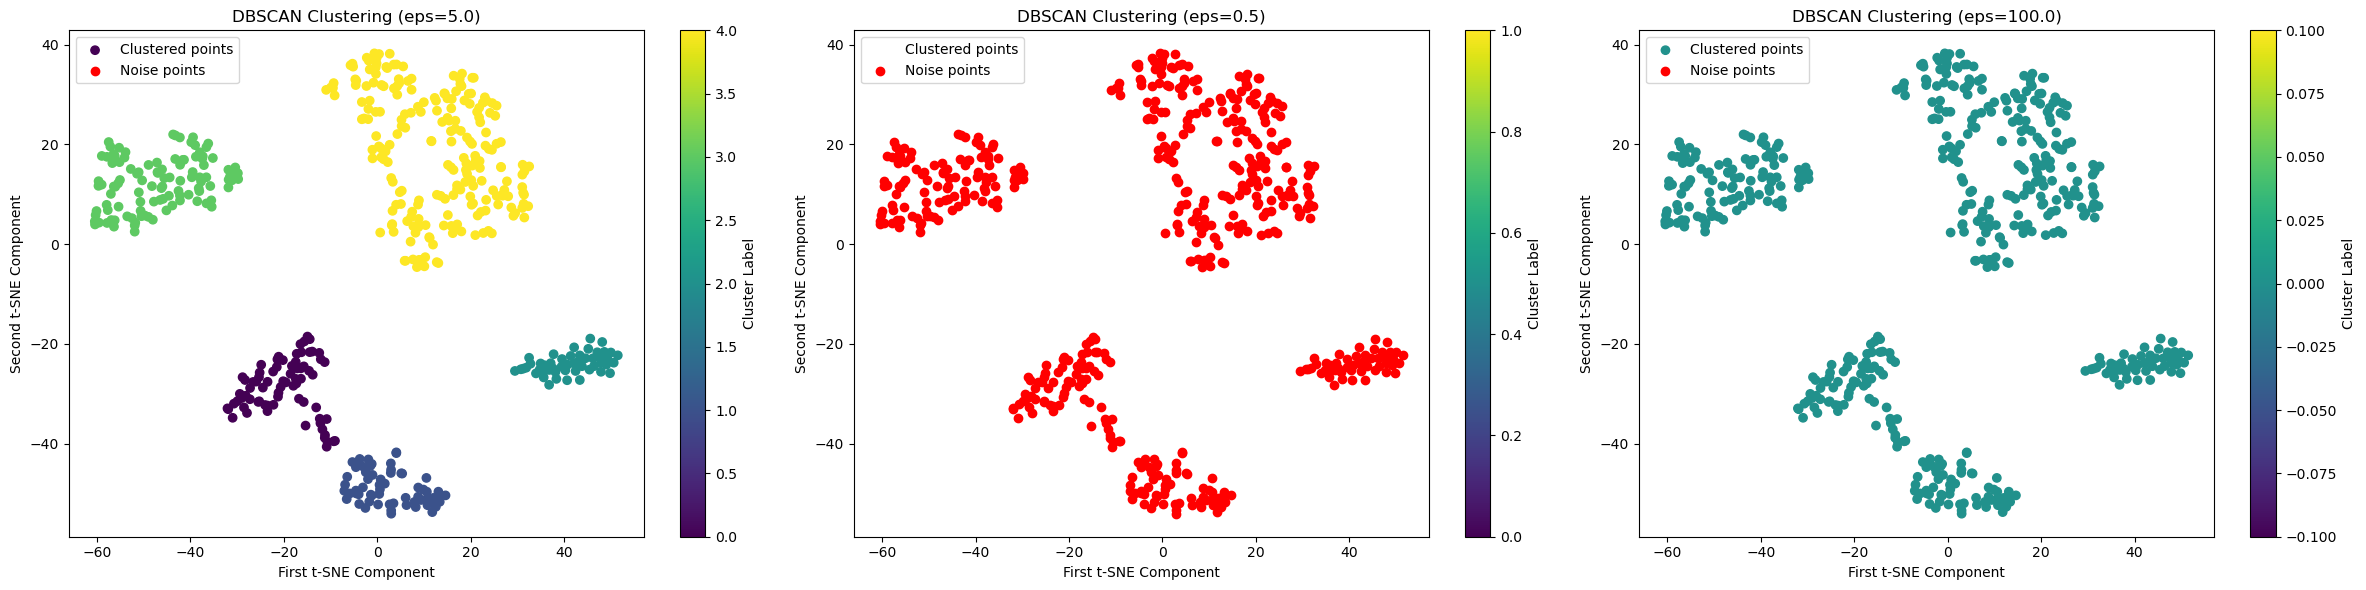


DBSCAN Clustering Results:
+-------------+----------------------+--------------------------+
| Parameter   |   Number of Clusters |   Number of Noise Points |
+=============+======================+==========================+
| eps=5.0     |                    5 |                        0 |
+-------------+----------------------+--------------------------+
| eps=0.5     |                    0 |                      511 |
+-------------+----------------------+--------------------------+
| eps=100.0   |                    1 |                        0 |
+-------------+----------------------+--------------------------+


In [12]:
# Import DBSCAN
from sklearn.cluster import DBSCAN

# Create figure with 3 subplots in one row
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))

# Try DBSCAN with eps=5.0
dbscan = DBSCAN(eps=5.0)
clusters_eps5 = dbscan.fit_predict(X_tsne)

# Plot results for eps=5.0
mask = clusters_eps5 != -1
ax1.scatter(X_tsne[mask, 0], X_tsne[mask, 1], c=clusters_eps5[mask], cmap='viridis', label='Clustered points')
mask_noise = clusters_eps5 == -1
ax1.scatter(X_tsne[mask_noise, 0], X_tsne[mask_noise, 1], c='red', label='Noise points')
ax1.set_title('DBSCAN Clustering (eps=5.0)')
ax1.set_xlabel('First t-SNE Component')
ax1.set_ylabel('Second t-SNE Component')
fig.colorbar(ax1.collections[0], ax=ax1, label='Cluster Label')
ax1.legend()

# Try with eps=0.5 (likely too small)
dbscan_small = DBSCAN(eps=0.5)
clusters_small = dbscan_small.fit_predict(X_tsne)

# Plot results for eps=0.5
mask = clusters_small != -1
ax2.scatter(X_tsne[mask, 0], X_tsne[mask, 1], c=clusters_small[mask], cmap='viridis', label='Clustered points')
mask_noise = clusters_small == -1
ax2.scatter(X_tsne[mask_noise, 0], X_tsne[mask_noise, 1], c='red', label='Noise points')
ax2.set_title('DBSCAN Clustering (eps=0.5)')
ax2.set_xlabel('First t-SNE Component')
ax2.set_ylabel('Second t-SNE Component')
fig.colorbar(ax2.collections[0], ax=ax2, label='Cluster Label')
ax2.legend()

# Try with eps=100.0 (likely too large)
dbscan_large = DBSCAN(eps=100.0)
clusters_large = dbscan_large.fit_predict(X_tsne)

# Plot results for eps=100.0
mask = clusters_large != -1
ax3.scatter(X_tsne[mask, 0], X_tsne[mask, 1], c=clusters_large[mask], cmap='viridis', label='Clustered points')
mask_noise = clusters_large == -1
ax3.scatter(X_tsne[mask_noise, 0], X_tsne[mask_noise, 1], c='red', label='Noise points')
ax3.set_title('DBSCAN Clustering (eps=100.0)')
ax3.set_xlabel('First t-SNE Component')
ax3.set_ylabel('Second t-SNE Component')
fig.colorbar(ax3.collections[0], ax=ax3, label='Cluster Label')
ax3.legend()

plt.tight_layout()
plt.show()

# Create a table with the results
from tabulate import tabulate

results = [
    ["eps=5.0", len(set(clusters_eps5)) - (1 if -1 in clusters_eps5 else 0), sum(clusters_eps5 == -1)],
    ["eps=0.5", len(set(clusters_small)) - (1 if -1 in clusters_small else 0), sum(clusters_small == -1)],
    ["eps=100.0", len(set(clusters_large)) - (1 if -1 in clusters_large else 0), sum(clusters_large == -1)]
]

print("\nDBSCAN Clustering Results:")
print(tabulate(results, headers=["Parameter", "Number of Clusters", "Number of Noise Points"], tablefmt="grid"))


## Compare DBSCAN with Lables 


In [13]:
nmi_dbscan = normalized_mutual_info_score(y, clusters_eps5)
print(f"\nNormalized Mutual Information between DBSCAN (eps=5.0) and original labels: {nmi_dbscan:.3f}")

# Add interpretation
print("\nInterpretation:")
if nmi_dbscan > 0.8:
    print("The DBSCAN clustering shows very strong agreement with the domain experts' labels")
elif nmi_dbscan > 0.5:
    print("The DBSCAN clustering shows moderate agreement with the domain experts' labels")
else:
    print("The DBSCAN clustering shows relatively weak agreement with the domain experts' labels")



Normalized Mutual Information between DBSCAN (eps=5.0) and original labels: 0.965

Interpretation:
The DBSCAN clustering shows very strong agreement with the domain experts' labels


## Plot the t-SNE data colored by the given labels

/var/folders/yv/1fmjzcsn6xs23xrlfnvvd82w0000gn/T/ipykernel_12490/187358625.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


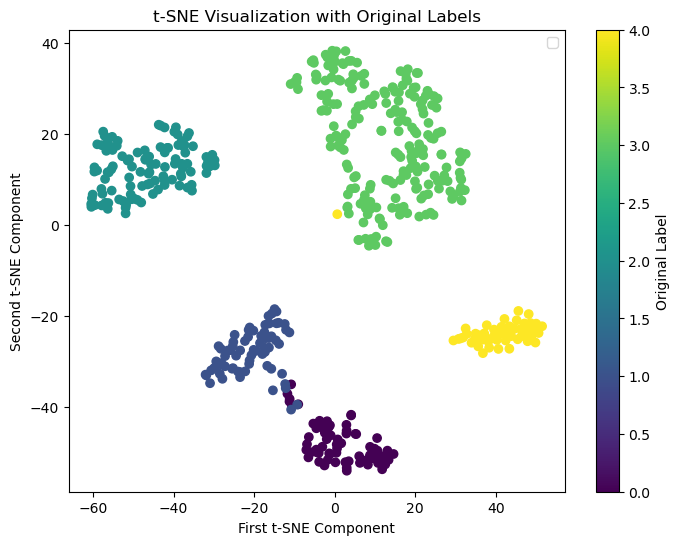


Silhouette Score for original labels: 0.642

Interpretation of separation:
The data points show good separation based on the original labels


In [14]:
from sklearn.metrics import silhouette_score
# Create a scatter plot of t-SNE results colored by original labels
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis')
plt.colorbar(scatter, label='Original Label')
plt.title('t-SNE Visualization with Original Labels')
plt.xlabel('First t-SNE Component')
plt.ylabel('Second t-SNE Component')
plt.legend()
plt.show()

# Calculate silhouette score to quantify separation
silhouette_avg = silhouette_score(X_tsne, y)
print(f"\nSilhouette Score for original labels: {silhouette_avg:.3f}")

print("\nInterpretation of separation:")
if silhouette_avg > 0.5:
    print("The data points show good separation based on the original labels")
elif silhouette_avg > 0.25:
    print("The data points show moderate separation based on the original labels")
else:
    print("The data points show poor separation based on the original labels")


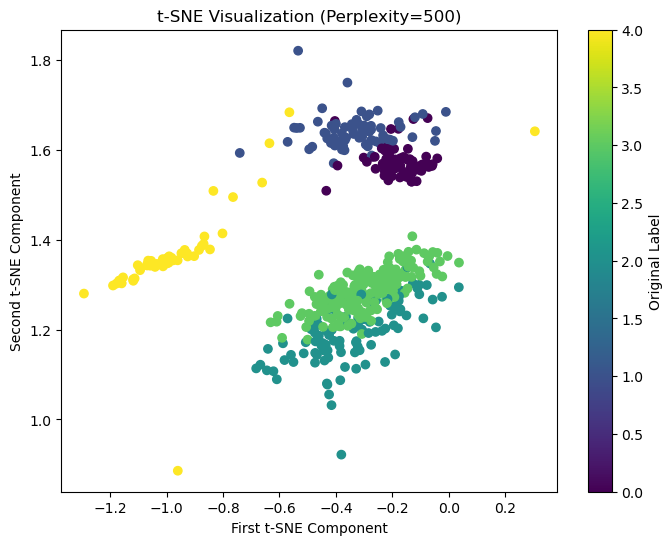


Visual Analysis:
With perplexity=500, the points are pulled closer together compared to the default perplexity.
The clusters appear more compressed, making it harder to distinguish clear boundaries between groups.
Based on visual inspection, there seem to be approximately 3-4 main clusters,
though the boundaries between them are less distinct due to the higher perplexity value.


In [15]:
# Perform t-SNE with perplexity=500
tsne_500 = TSNE(n_components=2, perplexity=500, random_state=42)
X_tsne_500 = tsne_500.fit_transform(X)

# Create scatter plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_tsne_500[:, 0], X_tsne_500[:, 1], c=y, cmap='viridis')
plt.colorbar(scatter, label='Original Label')
plt.title('t-SNE Visualization (Perplexity=500)')
plt.xlabel('First t-SNE Component')
plt.ylabel('Second t-SNE Component')
plt.show()

print("\nVisual Analysis:")
print("With perplexity=500, the points are pulled closer together compared to the default perplexity.")
print("The clusters appear more compressed, making it harder to distinguish clear boundaries between groups.")
print("Based on visual inspection, there seem to be approximately 3-4 main clusters,")
print("though the boundaries between them are less distinct due to the higher perplexity value.")
